<a href="https://colab.research.google.com/github/DenuraTHEbest/InvestHere/blob/Amna_S/aspiFinal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data: (602, 27), Testing Data: (151, 27)
Model training completed.
MAE for day 1: 178.55806622516283
MAE for day 2: 209.78737748344238
MAE for day 3: 237.03890993377283
MAE for day 4: 261.10021258277976
MAE for day 5: 312.00313443708524
MAE for day 6: 322.7268913907262
MAE for day 7: 374.8181264900626
MAE for day 8: 466.6100437086044
MAE for day 9: 521.9803331125772
MAE for day 10: 552.0138682119181
MAE for day 11: 575.3485754966863
MAE for day 12: 566.8841331125811
MAE for day 13: 551.0669788079458
MAE for day 14: 538.133631788079
MAE for day 15: 551.72569602649
MAE for day 16: 558.3486682119202
MAE for day 17: 542.780275496689
MAE for day 18: 541.1794178807958
MAE for day 19: 541.7706205298018
MAE for day 20: 553.972803311259
R2 for day 1: 0.8674549477371923
R2 for day 2: 0.8096455208105503
R2 for day 3: 0.7643070900453999
R2 for day 4: 0.718211492

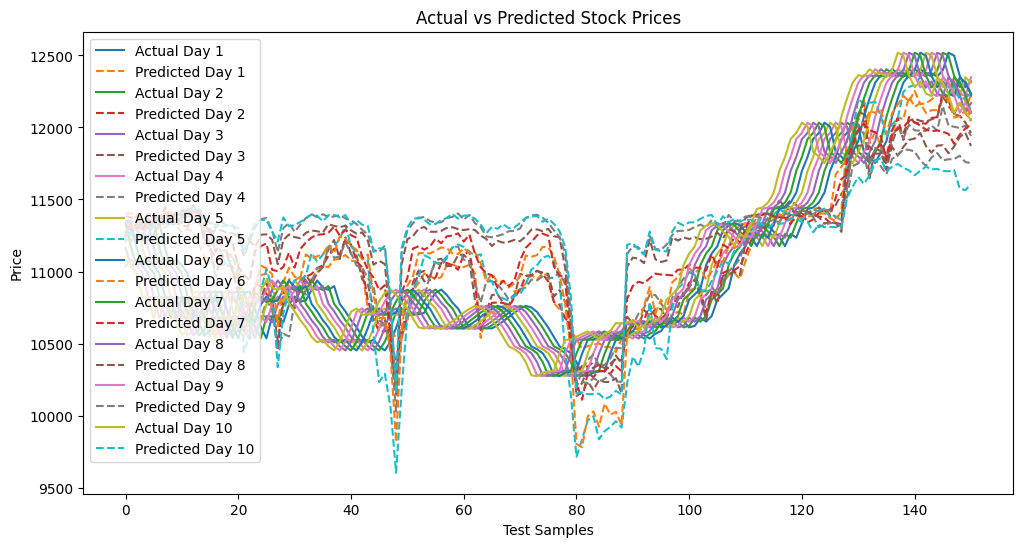

Feature columns (X): ['Date', 'Weighted_Sentiment', 'Lagged_Sentiment_1', 'Lagged_Sentiment_2', 'Lagged_Sentiment_3', 'Lagged_Sentiment_4', 'Lagged_Sentiment_5', 'Lagged_Sentiment_6', 'Lagged_Sentiment_7', 'Lagged_Sentiment_8', 'Lagged_Sentiment_9', 'Price_Lag1', 'Price_Lag2', 'Price_Lag3', 'Price_Lag4', 'Price_Lag5', 'Price_Lag6', 'Price_Lag7', 'Price_Lag8', 'Price_Lag9', 'Price_Lag10', 'Price_Lag12', 'Price_Lag15', 'Price_Lag18', 'Price_Lag20', 'Price_Lag25', 'Price_Lag30']


In [19]:
import pandas as pd
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Load datasets
aspi_data = pd.read_csv('/content/drive/My Drive/CSE_All_Share_Historical_Data_Processed.csv')
sentiment_data = pd.read_csv('/content/drive/My Drive/daily_weighted_scores_9-12.csv')

# Convert the Date columns to pandas datetime for both datasets
aspi_data['Date'] = pd.to_datetime(aspi_data['Date'])  # Already in YYYY-MM-DD format
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])  # Already in YYYY-MM-DD format

# Filter for the common date range
common_start_date = max(aspi_data['Date'].min(), sentiment_data['Date'].min())
common_end_date = min(aspi_data['Date'].max(), sentiment_data['Date'].max())

aspi_data = aspi_data[(aspi_data['Date'] >= common_start_date) & (aspi_data['Date'] <= common_end_date)]
sentiment_data = sentiment_data[(sentiment_data['Date'] >= common_start_date) & (sentiment_data['Date'] <= common_end_date)]

# Sort both datasets by date in ascending order
aspi_data = aspi_data.sort_values(by='Date')
sentiment_data = sentiment_data.sort_values(by='Date')

# Merge datasets with lagged sentiment features
for lag in range(1, 10):  # 9 days lag
    sentiment_data[f'Lagged_Sentiment_{lag}'] = sentiment_data['Weighted_Sentiment'].shift(lag)

# Drop rows with NaN values introduced by shifting
sentiment_data = sentiment_data.dropna(subset=[f'Lagged_Sentiment_{lag}' for lag in range(1, 10)])

# Merge the sentiment data with the ASPI data
merged_data = pd.merge(aspi_data[['Date', 'Price']], sentiment_data[['Date', 'Weighted_Sentiment'] + [f'Lagged_Sentiment_{lag}' for lag in range(1, 10)]],
                       on='Date', how='left')

# Create lagged price features (10, 20, 30 days)
for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30]:
    merged_data[f'Price_Lag{lag}'] = merged_data['Price'].shift(lag)

# Drop rows with NaN values (from shifting and moving averages)
merged_data = merged_data.dropna()

# Create target variables for the next 20 days
for i in range(1, 21):
    merged_data[f'Target_{i}'] = merged_data['Price'].shift(-i)

# Remove rows with NaN values (from shifting)
merged_data = merged_data.dropna()

# Convert Date to numerical format (Unix timestamp)
merged_data['Date'] = merged_data['Date'].astype(np.int64) // 10**9  # Convert to Unix timestamp

# Features (X) and Target (y)
X = merged_data.drop(columns=['Price'] + [f'Target_{i}' for i in range(1, 21)])
y = merged_data[[f'Target_{i}' for i in range(1, 21)]]

# Sort data by Date to ensure we train from oldest to newest
merged_data = merged_data.sort_values(by='Date')

# Split the data into train (80%) and test (20%) while preserving time order
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# Initialize and train Multi-Output RandomForestRegressor
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

print("Model training completed.")

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance using Mean Absolute Error (MAE) for each day ahead
mae_scores = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Evaluate model performance using r2
r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Print MAE and R2 results
for i, mae in enumerate(mae_scores, 1):
    print(f"MAE for day {i}: {mae}")

for i, r2 in enumerate(r2_scores, 1):
    print(f"R2 for day {i}: {r2}")

# Show predicted and actual values for the first 10 predictions
predicted_values = pd.DataFrame(y_pred, columns=[f'Predicted_{i}' for i in range(1, 21)])
actual_values = y_test.reset_index(drop=True)

# Extract the Date column from the merged_data DataFrame
dates = merged_data['Date'].iloc[split_index:].reset_index(drop=True)

# Merge the predicted and actual values with the Date column
comparison_df = pd.concat([dates, actual_values, predicted_values], axis=1)

# Display the first few rows for comparison
print(comparison_df.head(20))

# Optional: Plot Actual vs Predicted for the first 10 days of predictions
plt.figure(figsize=(12, 6))
for i in range(1, 11):
    plt.plot(comparison_df[f'Target_{i}'], label=f'Actual Day {i}')
    plt.plot(comparison_df[f'Predicted_{i}'], label=f'Predicted Day {i}', linestyle='--')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Print the feature columns (X)
print("Feature columns (X):", X.columns.tolist())